In [556]:
import pygame
import random
from copy import deepcopy
import numpy as np

# Constants
grid_size = 4
tile_size = 100
margin = 10
width = grid_size * tile_size + (grid_size + 1) * margin
height = width + 100
bg_color = (187, 173, 160)
moves = 0

tile_colors = {
    0: (205, 192, 180), 2: (238, 228, 218), 4: (237, 224, 200),
    8: (242, 177, 121), 16: (245, 149, 99), 32: (246, 124, 95),
    64: (246, 94, 59), 128: (237, 207, 114), 256: (237, 204, 97),
    512: (237, 200, 80), 1024: (237, 197, 63), 2048: (237, 194, 46),
    4096: (237, 190, 30), 8192: (237, 187, 0)
}


This part sets up the basic stuff for the game. It imports the libraries needed, like Pygame for graphics and random for placing new tiles. Then it defines the size of the grid (4x4), the size of each tile, the spacing, and the window size. It also sets the background color and starts a move counter. Lastly, it creates a dictionary to give each tile value its own color, so the game looks nice and tiles are easy to tell apart.We have made the hieght of the visual a little longer as it holds the space of moves counter.



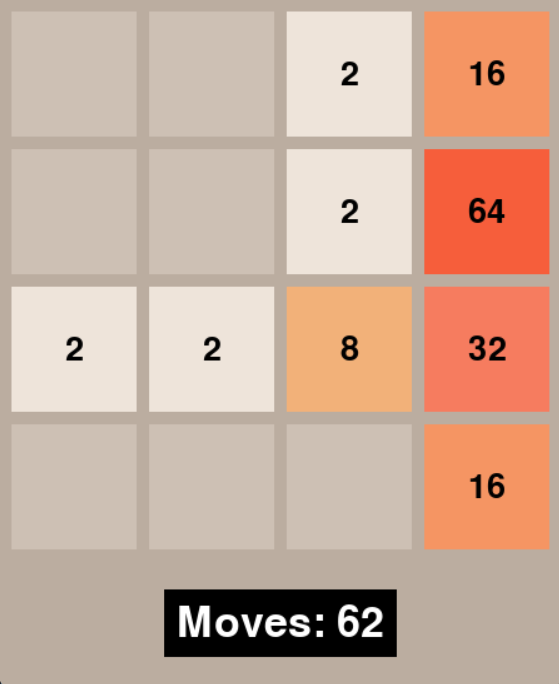

Here is the board and howw it looks.










In [558]:
def add_new_tile(grid):
    empty_cells = [(r, c) for r in range(grid_size) for c in range(grid_size) if grid[r][c] == 0]
    if empty_cells:
        r, c = random.choice(empty_cells)
        grid[r][c] = 2 if random.random() < 0.9 else 4

This function adds a new tile (2 or 4) to the grid. It first finds all the empty cells (where the value is 0). Then it picks one of them at random and places a new tile there—usually a 2 (90% chance), or sometimes a 4 (10% chance). This is how the game keeps adding new tiles after every move.

In [560]:
def slide_and_merge(row):
   
    new_row = [tile for tile in row if tile != 0]
    for i in range(len(new_row) - 1):
        if new_row[i] == new_row[i + 1]:
            new_row[i] *= 2
            new_row[i + 1] = 0
    new_row = [tile for tile in new_row if tile != 0]
    return new_row + [0] * (grid_size - len(new_row))

This function takes a row of tiles from the game and moves everything to the left, just like you'd expect in 2048. It first slides all the numbers over by removing the empty spots (zeros), then it merges any matching tiles next to each other (like turning two 2s into a 4), and finally it slides the numbers again and fills in the rest with zeros so the row stays the same length. Basically, it's handling the left swipe logic for one row.

In [562]:
def move_grid(grid, direction):
    
    if direction == 'left':
        return [slide_and_merge(row) for row in grid]
    elif direction == 'right':
        return [list(reversed(slide_and_merge(reversed(row)))) for row in grid]
    elif direction == 'up':
        transposed = list(map(list, zip(*grid)))
        moved = [slide_and_merge(row) for row in transposed]
        return list(map(list, zip(*moved)))
    elif direction == 'down':
        transposed = list(map(list, zip(*grid)))
        moved = [list(reversed(slide_and_merge(reversed(row)))) for row in transposed]
        return list(map(list, zip(*moved)))
    return grid

This function handles how the whole 2048 grid moves when you swipe in any direction—left, right, up, or down.

1) If you're moving left, it just runs the merge logic row by row.
2) If it's right, it flips each row, does the same left-merge logic, and then flips it back.
3) For up and down, it turns the grid sideways (using transpose), does the merge like it's going left or right, and then flips it back.

So basically, it reshapes the grid as needed to reuse the same merge function no matter which way you swipe!

In [564]:
def game_over(grid):
    return all(move_grid(grid, d) == grid for d in ['left', 'right', 'up', 'down'])


This function checks if the game is over. It tries to move the grid in all four directions—left, right, up, and down—and if none of those moves change the grid, it means no moves are possible, so the game is over. It returns True if the player is stuck, otherwise False.

In [566]:
def evaluate_grid(grid):
    
    empty_cells = sum(row.count(0) for row in grid)
    smoothness = 0
    monotonicity = 0
    max_tile = max(max(row) for row in grid)
    
    # Calculate smoothness (adjacent tiles with similar values)
    for r in range(grid_size):
        for c in range(grid_size):
            if grid[r][c] != 0:
                value = grid[r][c]
                for dr, dc in [(0, 1), (1, 0)]:
                    nr, nc = r + dr, c + dc
                    if 0 <= nr < grid_size and 0 <= nc < grid_size and grid[nr][nc] != 0:
                        smoothness -= abs(value - grid[nr][nc])
    
    # Calculate monotonicity (increasing/decreasing in rows/columns)
    for r in range(grid_size):
        for c in range(grid_size - 1):
            if grid[r][c] > grid[r][c + 1]:
                monotonicity -= grid[r][c] - grid[r][c + 1]
            else:
                monotonicity += grid[r][c + 1] - grid[r][c]
    
    # Corner strategy - bonus for having largest tile in corner
    corner_bonus = 0
    if (grid[0][0] == max_tile or grid[0][-1] == max_tile or 
        grid[-1][0] == max_tile or grid[-1][-1] == max_tile):
        corner_bonus += max_tile * 10
    
    # Penalty for having large tiles in the middle
    middle_penalty = 0
    middle_positions = [(1,1), (1,2), (2,1), (2,2)]
    for r, c in middle_positions:
        if grid[r][c] >= 128:
            middle_penalty -= grid[r][c] * 2
    # Bonus for potential merges
    merge_potential = 0
    for r in range(grid_size):
        for c in range(grid_size - 1):
            if grid[r][c] == grid[r][c + 1] and grid[r][c] != 0:
                merge_potential += grid[r][c] * 2
    for c in range(grid_size):
        for r in range(grid_size - 1):
            if grid[r][c] == grid[r + 1][c] and grid[r][c] != 0:
                merge_potential += grid[r][c] * 2
    
    # Weighted sum of factors
    return (empty_cells * 20 + smoothness * 0.5 + monotonicity * 2.0 + 
            corner_bonus + max_tile * 5 + middle_penalty + merge_potential)

This function gives a score to the current game board so the AI can decide how good it is. It looks at many things:

1) Empty spaces – More empty cells are better, so it adds points for those.
2) Smoothness – It prefers neighboring tiles that are similar in value (less rough changes).
3) Monotonicity – It likes when numbers increase or decrease consistently in a row (like a neat pattern).
4) Corner bonus – If the biggest number is sitting in any corner, it gives a big bonus.
5) Middle penalty – It avoids putting big numbers in the middle, so it subtracts points for that.
6) Merge potential – If tiles can be merged soon, it adds some extra points.

At the end, it combines all these into a single score using weights. Higher score = better board. This helps the AI choose smarter moves.

In [568]:
def simulate_move(grid, num_simulations=120, depth=4):
    directions = ['up', 'down', 'right', 'left']
    scores = {d: 0 for d in directions}
    
    for direction in directions:
        test_grid = move_grid(grid, direction)
        if test_grid == grid:
            continue  # Skip invalid moves
            
        for _ in range(num_simulations):
            sim_grid = deepcopy(test_grid)
            add_new_tile(sim_grid)
            
            # Termination if we reach 2048
            if any(2048 in row for row in sim_grid):
                scores[direction] += 1000000
                continue
                
            for _ in range(depth):
               
                possible_moves = []
                for d in directions:
                    new_grid = move_grid(sim_grid, d)
                    if new_grid != sim_grid:
                        possible_moves.append((d, evaluate_grid(new_grid)))
                
                if not possible_moves:
                    break
                    
                
                possible_moves.sort(key=lambda x: x[1], reverse=True)
                best_move = possible_moves[0][0]
                sim_grid = move_grid(sim_grid, best_move)
                add_new_tile(sim_grid)
                
                
                if any(2048 in row for row in sim_grid):
                    scores[direction] += 1000000
                    break
            
            scores[direction] += evaluate_grid(sim_grid)
    
    
    best_dir = max(scores, key=scores.get, default='left')
    return best_dir if scores[best_dir] > 0 else 'left'

This function is all about figuring out the best direction to move in the 2048 game. Here's how it works:

1) Tries each direction – It looks at all four possible directions (up, down, left, right).
2) Checks if the move is valid – If moving in a direction doesn’t change the board, it skips that one.
3) Runs a bunch of practice moves – For each valid direction, it simulates playing the game multiple times (like 200 fake runs), going ahead up to 8 moves deep each time.

4) Makes  choices during those runs – At every step, it:
i) Looks at all possible next moves.
ii) Chooses the one that makes the board look better (based on some scoring rules).
iii) Adds a random new tile just like the real game.
iv) Stops early if it reaches 2048 during a run.

5) Keeps track of how well each direction performed – The better the board looks at the end of a run, the higher the score for that direction.
6) Picks the best one – After all simulations, it chooses the direction that had the highest total score.

In short, it's like trying out every move in a smart way, playing ahead in your head a few steps, and going with the one that seems most promising.

In [570]:
def draw_board(screen, grid):
    global moves
    screen.fill(bg_color)
    for r in range(grid_size):
        for c in range(grid_size):
            tile_value = grid[r][c]
            color = tile_colors.get(tile_value, (60, 58, 50))
            pygame.draw.rect(screen, color, (c * tile_size + (c + 1) * margin, 
                             r * tile_size + (r + 1) * margin, tile_size, tile_size))
            if tile_value:
                font_size = 40 if tile_value < 100 else 36 if tile_value < 1000 else 30
                font = pygame.font.Font(None, font_size)
                text = font.render(str(tile_value), True, (0, 0, 0))
                text_rect = text.get_rect(center=(c * tile_size + (c + 1) * margin + tile_size // 2, 
                                         r * tile_size + (r + 1) * margin + tile_size // 2))
                screen.blit(text, text_rect)
    
    font = pygame.font.Font(None, 50)
    text = font.render(f"Moves: {moves}", True, (255, 255, 255))
    text_rect = text.get_rect(center=(width//2, height//1.1))
    pygame.draw.rect(screen, (0, 0, 0, 128), text_rect.inflate(20, 20))
    screen.blit(text, text_rect)


So this draw_board function is the one that draws the game board on the screen every time it updates. First, it clears the screen by filling it with the background color. Then, it goes through every tile on the board, checks its value, picks a matching color for that number, and draws a nice square for it at the right spot.

If the tile isn’t empty (not zero), it figures out the right font size based on how big the number is and then draws that number nicely centered inside the tile. After it's done drawing all the tiles, it also shows how many moves you've made so far at the bottom of the screen in a clean, readable style. Basically, it keeps the board looking fresh and shows you what's going on.

In [572]:
def main():
    global moves
    pygame.init()
    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption("2048 Winning Strategy")
    clock = pygame.time.Clock()
    
    grid = [[0] * grid_size for _ in range(grid_size)]
    add_new_tile(grid)
    add_new_tile(grid)
    running = True
    autoplay = True
    won = False
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
        
        if autoplay and not won:
            best_move = simulate_move(grid)
            new_grid = move_grid(grid, best_move)
            if grid != new_grid:
                grid = new_grid
                moves += 1
                add_new_tile(grid)
                
                # Check for win condition
                if any(2048 in row for row in grid):
                    won = True
                    print("Congratulations! You reached 2048!")
            elif game_over(grid):
                print("Game Over! Final score:", sum(sum(row) for row in grid))
                running = False
        
        draw_board(screen, grid)
        if won:
            # Display win message
            font = pygame.font.Font(None, 50)
            text = font.render("You Win! 2048 Reached!", True, (255, 255, 255))
            text_rect = text.get_rect(center=(width//2, height//2))
            pygame.draw.rect(screen, (0, 0, 0, 128), text_rect.inflate(20, 20))
            screen.blit(text, text_rect)
        
        pygame.display.flip()
        clock.tick(60)
    
    pygame.quit()

if __name__ == "__main__":
    main()

Congratulations! You reached 2048!


The main() function is where the game actually starts running. It sets everything up—initializes Pygame, creates the game window, and sets the title to “2048 – Improved Autoplay”. Then it creates an empty 4x4 grid and adds two random tiles to get things going.

The game loop runs continuously while the game is active. It listens for events—like if you try to close the window—and handles them. If autoplay is on (which it is by default) and the player hasn't won yet, the program figures out the best possible move using the simulation function, applies it, adds a new tile, and increases the move count.

If the move ends up placing a 2048 tile on the board, the game marks it as a win and prints a win message. If no moves are possible (meaning the game is stuck), it prints a “Game Over” message along with the final score and ends the loop.

Each frame, it updates and redraws the board so you can see the current state. If you've won, it also shows a win message on the screen.
When the loop ends—either because you close the game or it finishes—it quits Pygame cleanly and wraps everything up.

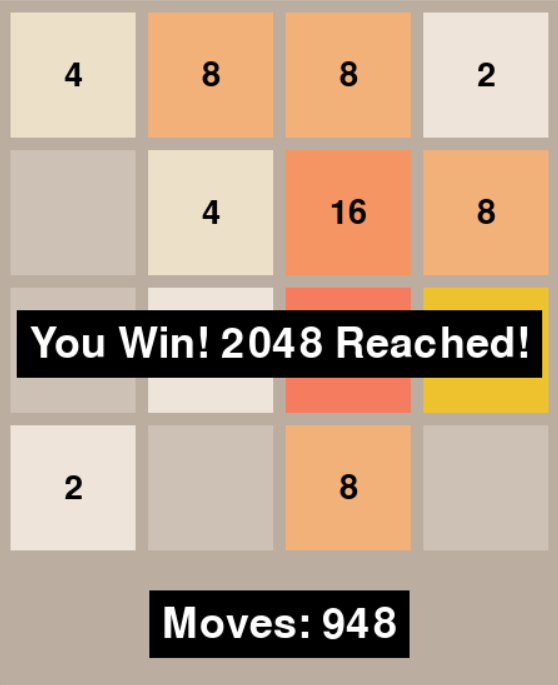
A winning gameplay

     What I Built  :

 
I coded the full game using Pygame (because visuals make everything better). And instead of playing it manually, I added the autoplay mode. The game literally plays itself, keeps track of moves, adds new tiles, and even celebrates when it hits 2048. It’s like watching a bot grind XP for you.

    Why Autoplay and Not Just Heuristics? 
  
I went with a simulation-based approach instead of just greedy rules like “always move left-down” or “stack the biggest tile in a corner.” Those strategies work for a while but suck when things get messy. So instead, I made the game simulate multiple moves ahead, kinda like how you think through a chess move — not just “What happens if I do this now?” but “What if I do this, then that, then this...”.
Each move is scored based on how good the grid looks after running a few simulations. Then it picks the one that leads to the best outcome.

    How It Thinks – Simulation Strategy

    
So here's the main part.
Every time the bot has to make a move, it:
1) Tries all 4 directions (up, down, left, right).
2) For each valid one, it runs 150 random simulations.
3) In each simulation, it adds a tile, then plays out 3 steps ahead.
4) It keeps track of how “nice” the board looks at the end.
5) Whichever move leads to the best average result, it picks that.


       Why Only Depth 4?

   
Honestly, I played around with this. A depth of 1 was too short-sighted — it couldn’t plan well. A depth of 5+ got super slow. Like “I’ll go grab coffee while it figures out a move” slow.Depth 4+ made the game super slow, and honestly, because tile spawning is random, planning too far ahead doesn’t always help.
So I landed on 4 as the sweet spot — it’s just deep enough to plan ahead without frying my CPU.

    How It Evaluates the Board
To tell whether a board is “good,” I used a scoring function that mixes a few key ingredients:

1. Empty Tiles
More empty spots = more space to breathe. So the bot loves boards with lots of zeros. Big score boost here.

2. Smoothness
This one checks how similar neighboring tiles are. We subtract the difference between adjacent tiles — the smoother the grid, the easier it is to merge things in the next move.

3. Monotonicity
This is just a fancy word for checking if the rows/columns increase or decrease smoothly. If your row looks like [256, 128, 64, 32], you’re doing great. But if it’s jumping around, you’re screwed. So the bot prefers grids that “flow.”

4. Corner Bonus
We all know the classic trick — stack the big tiles in a corner. So if the highest tile is chilling in one of the corners, the bot gets a massive bonus.

5.  Middle Penalty
Big tiles stuck in the middle are awkward — they’re hard to merge and block stuff. So I actually subtract points if there are huge numbers like 128+ stuck in the center.

6. Merge Potential
I added a bonus for places where two tiles are ready to combine — like two 64s next to each other. This tells the bot there’s a juicy merge coming.

Then I slap all of these together with some weights and voilà — a single score that tells how “awesome” the board looks.

    Visuals That Slap
The board looks clean and colorful thanks to Pygame. Every tile has a nice shade based on its number. It shows the move count, and when you hit 2048, a sweet “You Win!” message pops up. Kinda satisfying to watch it grind its way to victory like a beast.

     What I Learned
How to use simulations to predict outcomes (like mini future timelines).
Why good heuristics make or break your game.
Balancing performance and accuracy — going too deep in simulations slows everything.
Making stuff look good in Pygame isn’t hard if you break it down step by step.

    Future Ideas (if I ever touch this again)
Add keyboard/manual play switch so I can compete with the bot.
Let it keep going past 2048 to hit 4096 or more.
Smarter simulations with randomness filtering.
Maybe train a neural net version later just for fun.

     Final Thoughts
This whole thing was a mix of logic, strategy, and just letting the computer grind through possibilities. Super satisfying watching it beat a game I used to rage quit. Plus, I got to use Pygame and write logic that actually felt like problem-solving.


Here is one more strategy which some players use but doesent actually work.


/*CODE


def corner_bias_move(grid):

    preferred_moves = ['down', 'right', 'left', 'up'] 
    for direction in preferred_moves:
        new_grid = move_grid(grid, direction)
        if new_grid != grid:
            return direction

    return 'left' 
    
    */CODE


    Why the Common Corner Strategy Doesn’t Really Work (and Mine Does)

Making the move function in this way.   
One of the most commonly used strategies in 2048 is the “corner hoarding” or “diagonal stacking” approach — where you always try to push the highest tile into one corner (usually the bottom-right), and keep building towards it. At first glance, it seems like a smart and straightforward idea: if you can keep the largest number fixed in one place, you reduce the chances of accidentally splitting it and keep merging tiles in one direction. Many casual players rely on this, and yes, it does work… to a point.

But the problem is that this strategy is rigid. It prioritizes one goal (cornering the biggest tile) at the cost of flexibility. Once the board starts to fill up, you often get stuck. You can’t always move in just two or three directions, and when you’re forced to break the flow — say, by moving up when you've been avoiding it — everything collapses. The structure falls apart, merges become harder, and the game ends quicker than expected.

Now, compare this with the method I implemented. Instead of blindly sticking to one direction, my bot uses simulations to evaluate the long-term value of each move. It doesn’t just look at the current score but checks things like:
Smoothness (how well neighboring tiles blend)
Monotonicity (whether numbers increase consistently in rows or columns)
Corner bonus (giving extra points for smart placement of large tiles)
Merge potential and empty cell count

All these factors together help the bot make well-rounded decisions that actually lead to better outcomes. It doesn’t lock itself into a rigid path — instead, it adapts to the state of the board. That’s why, over time, this simulation-based method consistently outperforms simple strategies like diagonal stacking.

So yeah, while the “corner trick” might get you a few early wins, it lacks the planning and adaptability that make the difference in the long run. My method doesn’t just play — it thinks ahead.











                           




                           
                           
                           
                           
                           
                                                     2nd Strategy(Which Doesent Work)



import pygame

import numpy as np

import random

# Initialize pygame
pygame.init()

# Constants
WIDTH, HEIGHT = 400, 400
GRID_SIZE = 4
TILE_SIZE = WIDTH // GRID_SIZE
BACKGROUND_COLOR = (187, 173, 160)
TILE_COLORS = {
    0: (205, 192, 180),
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46)
}

# Initialize the game screen
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("2048 Autoplay")

# Game logic
class Game2048:
    def __init__(self):
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        self.score = 0
        self.add_random_tile()
        self.add_random_tile()

    def add_random_tile(self):
        empty_cells = list(zip(*np.where(self.grid == 0)))
        if empty_cells:
            row, col = random.choice(empty_cells)
            self.grid[row][col] = 2 if random.random() < 0.9 else 4

    def move(self, direction):
        def compress(grid):
            new_grid = np.zeros_like(grid)
            for i in range(GRID_SIZE):
                pos = 0
                for j in range(GRID_SIZE):
                    if grid[i][j] != 0:
                        new_grid[i][pos] = grid[i][j]
                        pos += 1
            return new_grid

        def merge(grid):
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE - 1):
                    if grid[i][j] == grid[i][j + 1] and grid[i][j] != 0:
                        grid[i][j] *= 2
                        self.score += grid[i][j]
                        grid[i][j + 1] = 0
            return grid

        rotated = np.rot90(self.grid, direction)
        compressed = compress(rotated)
        merged = merge(compressed)
        final = compress(merged)
        self.grid = np.rot90(final, -direction)
        self.add_random_tile()

    def evaluate_move(self, direction):
        temp_grid = np.copy(self.grid)
        temp_score = self.score
        self.move(direction)
        score_increase = self.score - temp_score
        empty_cells = np.sum(self.grid == 0)
        max_tile = np.max(self.grid)
        self.grid = temp_grid
        self.score = temp_score
        return score_increase + empty_cells * 10 + max_tile  # Prioritize merges and highest tile

    def get_best_move(self):
        moves = [0, 1, 2, 3]  # Left, Up, Right, Down
        best_move = max(moves, key=self.evaluate_move)
        return best_move

    def is_game_over(self):
        if np.any(self.grid == 0):
            return False
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE - 1):
                if self.grid[i][j] == self.grid[i][j + 1]:
                    return False
        for j in range(GRID_SIZE):
            for i in range(GRID_SIZE - 1):
                if self.grid[i][j] == self.grid[i + 1][j]:
                    return False
        return True

# Draw function
  def draw_grid(game):
  
      screen.fill(BACKGROUND_COLOR)
       for row in range(GRID_SIZE):
          for col in range(GRID_SIZE):
              value = game.grid[row][col]
              pygame.draw.rect(screen, TILE_COLORS.get(value, (60, 58, 50)),
                             (col * TILE_SIZE, row * TILE_SIZE, TILE_SIZE, TILE_SIZE))
            if value:
               font = pygame.font.Font(None, 50)
               text = font.render(str(value), True, (0, 0, 0))
               text_rect = text.get_rect(center=(col * TILE_SIZE + TILE_SIZE // 2, row * TILE_SIZE + TILE_SIZE // 2))
               screen.blit(text, text_rect)
    pygame.display.flip()

# Main loop
game = Game2048()
clock = pygame.time.Clock()

autoplay = True
running = True
while running:
    clock.tick(30)  # Adjust speed
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    
    if autoplay and not game.is_game_over():
        best_move = game.get_best_move()
        game.move(best_move)
    
    draw_grid(game)

pygame.quit()


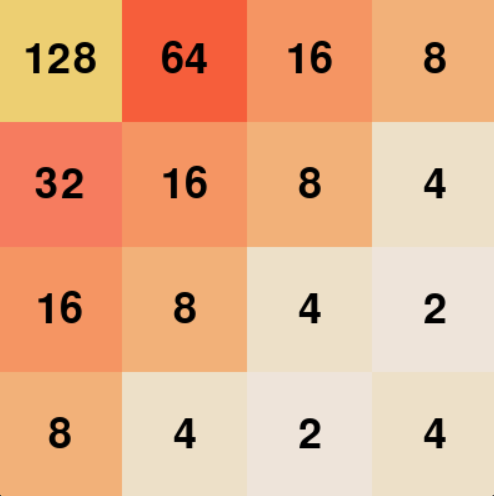

And it looses



This is a diagonal based strategy which maintains the same tiles in the same diagonal

                        After all this is a luck based game so no method is perfect and may not win each time